In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
pd.set_option("display.max_colwidth", 80)


# 実習の説明

## これは何か？

Jupyter notebook というRを使うためのインターフェースの一つです。

- Jupyter notebook の簡単な説明（日本語） https://datumstudio.jp/blog/795

特に、今回は JupyterHub という形で（みなさんの手元のPCではなく）オンラインでJupyter notebookを使う環境を提供しています。
これは、講義などで同一の環境でできるのに便利です。


## 何をするか？

非小細胞肺癌 (non-small-cell lung cancer; NSCLC) において、腫瘍組織内に存在する間質細胞から腫瘍細胞にシグナルのクロストークが送って腫瘍が活性化される可能性を探ります。データは、NSCLCモデルマウスと野生型のマウスの肺から、セルソーターで分けたマクロファージ、単球細胞、好中球、上皮細胞のRNA-seqデータです。

> このようなRNA-seqデータを、「変数が全遺伝子、条件が細胞型xマウス（野生型 or 腫瘍）、値が発現量である表」として想像できると、あとの解析がスムーズです

元ネタはこちら: 

- Toi _et al_., Transcriptome Analysis of Individual Stromal Cell Populations Identifies Stroma-Tumor Crosstalk in Mouse Lung Cancer Model, Cell Reports (2015) http://dx.doi.org/10.1016/j.celrep.2015.01.040 

ソフトウェアやアノテーションデータが著者らのウェブページで公開されています。また、NGSデータの生データや処理済みデータはGene Expression Omnibus (GEO)より公開されています。

- ソフトウェアやアノテーションデータ http://209.160.41.231/u54/CCCExplorer/
- Gene Expression Omnibus (GEO)のNGSデータのページ https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE59831

## どうやるか？

腫瘍組織内間質細胞のリガンドから腫瘍細胞の受容体へのシグナルのクロストークがあるとしたら、

- 腫瘍モデルマウスでは野生型に比べ、リガンドが発現上昇しているだろう
- 腫瘍モデルマウスの上皮組織では、そのリガンドの受容体が発現しているだろう

そのようなリガンドと受容体のペアを見つけるのに必要なデータは？

- 既知のリガンド-受容体ペアのデータベース（ヒト）
- ヒト-マウスオーソログの対応表
- 腫瘍組織内間質細胞で発現上昇がみられた遺伝子のリスト
- 腫瘍細胞で発現上昇

それらのデータを組み合わせればよさそう

In [217]:
col_names = [ 'c{0:02d}'.format(i) for i in range(14) ]
df=pd.read_csv('data/CCCExplorer/CD11CB_output/gene_exp.diff',names=col_names,sep='\t')
df.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,c10,c11,c12,c13
0,test_id,gene_id,gene,locus,sample_1,sample_2,status,value_1,value_2,log2(fold_change),test_stat,p_value,q_value,significant
1,0610005C13Rik,0610005C13Rik,-,chr7:45567794-45589710,q1,q2,NOTEST,0.0725212,0.044282,-0.711684,0,1,1,no
2,0610007C21Rik,0610007C21Rik,-,chr5:31036035-31054623,q1,q2,OK,50.2687,47.8496,-0.0711526,-0.229939,0.71855,0.839597,no
3,0610007N19Rik,0610007N19Rik,-,chr15:32240567-32244662,q1,q2,NOTEST,0.238515,0.0629525,-1.92174,0,1,1,no
4,0610007P08Rik,0610007P08Rik,-,chr13:63815319-63900301,q1,q2,OK,3.57436,3.11243,-0.199643,-0.57989,0.3616,0.542589,no


In [218]:
df2 = df.reset_index(drop=True)
df2.columns = df2.iloc[0]
df2=df2.drop(0)
df2.head()

,test_id,gene_id,gene,locus,sample_1,sample_2,status,value_1,value_2,log2(fold_change),test_stat,p_value,q_value,significant
1,0610005C13Rik,0610005C13Rik,-,chr7:45567794-45589710,q1,q2,NOTEST,0.0725212,0.044282,-0.711684,0,1,1,no
2,0610007C21Rik,0610007C21Rik,-,chr5:31036035-31054623,q1,q2,OK,50.2687,47.8496,-0.0711526,-0.229939,0.71855,0.839597,no
3,0610007N19Rik,0610007N19Rik,-,chr15:32240567-32244662,q1,q2,NOTEST,0.238515,0.0629525,-1.92174,0,1,1,no
4,0610007P08Rik,0610007P08Rik,-,chr13:63815319-63900301,q1,q2,OK,3.57436,3.11243,-0.199643,-0.57989,0.3616,0.542589,no
5,0610007P14Rik,0610007P14Rik,-,chr12:85815454-85824545,q1,q2,OK,11.6356,10.5723,-0.138247,-0.474073,0.5457,0.711416,no


In [219]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30743 entries, 1 to 30743
Data columns (total 14 columns):
test_id              30743 non-null object
gene_id              30743 non-null object
gene                 30743 non-null object
locus                30743 non-null object
sample_1             30743 non-null object
sample_2             30743 non-null object
status               30743 non-null object
value_1              30743 non-null object
value_2              30743 non-null object
log2(fold_change)    30743 non-null object
test_stat            30585 non-null object
p_value              30743 non-null object
q_value              30743 non-null object
significant          30743 non-null object
dtypes: object(14)
memory usage: 3.5+ MB


In [220]:
cols = ["value_1","value_2","log2(fold_change)","test_stat","p_value","q_value"]
for i in cols:
    df2[i] = df2[i].astype(float)

df2

,test_id,gene_id,gene,locus,sample_1,sample_2,status,value_1,value_2,log2(fold_change),test_stat,p_value,q_value,significant
1,0610005C13Rik,0610005C13Rik,-,chr7:45567794-45589710,q1,q2,NOTEST,0.072521,0.044282,-0.711684,0.000000,1.00000,1.000000,no
2,0610007C21Rik,0610007C21Rik,-,chr5:31036035-31054623,q1,q2,OK,50.268700,47.849600,-0.071153,-0.229939,0.71855,0.839597,no
3,0610007N19Rik,0610007N19Rik,-,chr15:32240567-32244662,q1,q2,NOTEST,0.238515,0.062952,-1.921740,0.000000,1.00000,1.000000,no
4,0610007P08Rik,0610007P08Rik,-,chr13:63815319-63900301,q1,q2,OK,3.574360,3.112430,-0.199643,-0.579890,0.36160,0.542589,no
5,0610007P14Rik,0610007P14Rik,-,chr12:85815454-85824545,q1,q2,OK,11.635600,10.572300,-0.138247,-0.474073,0.54570,0.711416,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30739,miR-202,miR-202,-,chr7:139950395-139992488,q1,q2,NOTEST,0.091154,0.228888,1.328260,0.000000,1.00000,1.000000,no
30740,miR-205,miR-205,-,chr1:193507239-193509803,q1,q2,NOTEST,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,no
30741,mmu-mir-155*,mmu-mir-155*,-,chr16:84713031-84715244,q1,q2,OK,0.110473,3.241200,4.874770,3.337930,0.25535,0.427191,no
30742,sr528,sr528,-,chr7:132889488-132985410,q1,q2,OK,15.874700,13.162700,-0.270267,-0.682664,0.28275,0.457470,no


ふむふむ

- 縦に遺伝子名のようなものが並んでいる。各行が遺伝子、各列が変数になっている
- `p_value`や`q_value`は発現変動を判定する統計検定の結果だろう
- `log2(fold_change)` は `value_2`/`value_1`をlog2変換したものだろう
    - ちなみに、`value_1` は正常組織でのマクロファージ、 `value_2` は腫瘍組織内マクロファージ (intratumoral macropahges)でのFPKMの平均値
    - これは __メタデータ__ をみないとわからない

In [221]:
df3 = df2[["gene_id", "value_1", "value_2", "log2(fold_change)","p_value", "q_value"]]
df3.head()

,gene_id,value_1,value_2,log2(fold_change),p_value,q_value
1,0610005C13Rik,0.072521,0.044282,-0.711684,1.00000,1.000000
2,0610007C21Rik,50.268700,47.849600,-0.071153,0.71855,0.839597
3,0610007N19Rik,0.238515,0.062952,-1.921740,1.00000,1.000000
4,0610007P08Rik,3.574360,3.112430,-0.199643,0.36160,0.542589
5,0610007P14Rik,11.635600,10.572300,-0.138247,0.54570,0.711416


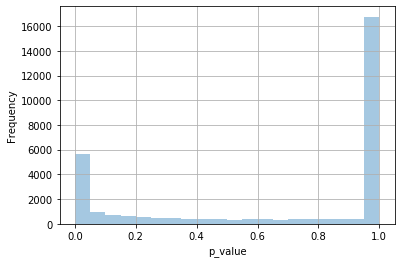

In [222]:
sns.distplot(df3["p_value"],bins=20,kde=False)
plt.ylabel("Frequency")
plt.grid()

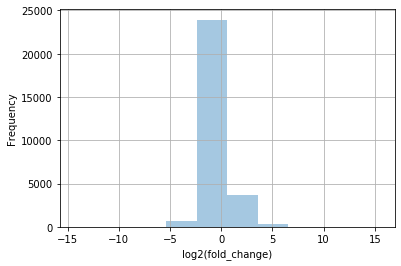

In [223]:
#infと-infをnanに変換してドロップする。
sns.distplot(df3["log2(fold_change)"].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna(),bins=10,kde=False)
plt.ylabel("Frequency")
plt.grid()

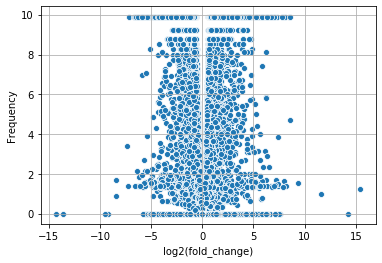

In [224]:
#infと-infをnanに変換してドロップする。
sns.scatterplot(df3["log2(fold_change)"].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna(),-np.log(df3["p_value"]))
plt.ylabel("Frequency")
plt.grid()

## 発現変動遺伝子の数を数える


- "intratumoral macrophages express increased cathepsin K, COX-2, MMP-9, PDGF-B, uPA, VEGFA, and HGF (Wang et al., 2011)"
    - Wang et al., 2011 http://www.sciencedirect.com/science/article/pii/S0169500211002546

In [225]:
# 腫瘍組織内マクロファージで多い (FC > 1.5, q_value < 0.1) 遺伝子の数は？

In [226]:
len(df3[(df3["log2(fold_change)"].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna()>np.log2(1.5))&(df3["p_value"] <0.1)])

2424

In [227]:
# ポジコンがとれるかの確認 (生物学的なQC)
df3[(df3["log2(fold_change)"].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna()>np.log2(1.5))&(df3["p_value"] <0.1)&(df3["gene_id"] == "Vegfa")]

,gene_id,value_1,value_2,log2(fold_change),p_value,q_value
29379,Vegfa,7.99474,167.936,4.39272,0.00005,0.00031


In [228]:
df3[(df3["log2(fold_change)"].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna()>np.log2(1.5))&(df3["p_value"] <0.1)&(df3["gene_id"] == "Mmp9")]

,gene_id,value_1,value_2,log2(fold_change),p_value,q_value
20561,Mmp9,0.088896,6.75021,6.24667,0.00005,0.00031


In [229]:
# 正常組織内マクロファージで多い (FC > 1/1.5, q_value < 0.1) の遺伝子の数は？
len(df3[(df3["log2(fold_change)"].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna()>-np.log2(1.5))&(df3["p_value"] <0.1)])

4244

------

------

------


# 本番
## 腫瘍組織内間質細胞で発現上昇する遺伝子のリストを得る

In [230]:
col_names = [ 'c{0:02d}'.format(i) for i in range(14) ]
deg_macrophage=pd.read_csv("data/CCCExplorer/CD11CB_output/gene_exp.diff",names=col_names,sep='\t')
deg_macrophage = deg_macrophage.reset_index(drop=True)
deg_macrophage.columns = deg_macrophage.iloc[0]
deg_macrophage=deg_macrophage.drop(0)
deg_macrophage["value_1"] = deg_macrophage["value_1"].astype(float)
deg_macrophage["value_2"] = deg_macrophage["value_2"].astype(float)
deg_macrophage["log2(fold_change)"] = deg_macrophage["log2(fold_change)"].astype(float)
deg_macrophage["test_stat"] = deg_macrophage["test_stat"].astype(float)
deg_macrophage["p_value"] = deg_macrophage["p_value"].astype(float)
deg_macrophage["q_value"] = deg_macrophage["q_value"].astype(float)
deg_macrophage = deg_macrophage[["gene_id", "value_1", "value_2", "log2(fold_change)","p_value", "q_value"]]
deg_macrophage.head()

,gene_id,value_1,value_2,log2(fold_change),p_value,q_value
1,0610005C13Rik,0.072521,0.044282,-0.711684,1.00000,1.000000
2,0610007C21Rik,50.268700,47.849600,-0.071153,0.71855,0.839597
3,0610007N19Rik,0.238515,0.062952,-1.921740,1.00000,1.000000
4,0610007P08Rik,3.574360,3.112430,-0.199643,0.36160,0.542589
5,0610007P14Rik,11.635600,10.572300,-0.138247,0.54570,0.711416


In [231]:
# とある条件で腫瘍組織内間質細胞で発現上昇する遺伝子をフィルタリング
deg_macrophage_tumor=deg_macrophage[(deg_macrophage["value_2"]>2)&(deg_macrophage["log2(fold_change)"].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna()>np.log2(1.5))&(deg_macrophage["p_value"] <0.1)]

# 何行 (何遺伝子)
len(deg_macrophage_tumor)


1966

## 腫瘍細胞で発現する遺伝子のリストを得る


In [232]:
# 遺伝子発現量 (FPKM) をまとめた表を読み込む (Cufflinksの出力だとおもう)
col_names = [ 'c{0:02d}'.format(i) for i in range(14) ]
fpkm_epi=pd.read_csv("data/CCCExplorer/EP_output/genes.read_group_tracking",names=col_names,sep='\t')
fpkm_epi = fpkm_epi.reset_index(drop=True)
fpkm_epi.columns = fpkm_epi.iloc[0]
fpkm_epi=fpkm_epi.drop(0)
cols = ["replicate","raw_frags","internal_scaled_frags","external_scaled_frags","FPKM"]
for i in cols:
    fpkm_epi[i] = fpkm_epi[i].astype(float)
fpkm_epi = fpkm_epi[["tracking_id", "condition", "replicate", "raw_frags","internal_scaled_frags", "external_scaled_frags","FPKM","effective_length","status"]]
fpkm_epi

,tracking_id,condition,replicate,raw_frags,internal_scaled_frags,external_scaled_frags,FPKM,effective_length,status
1,0610005C13Rik,q1,1.0,11.00000,12.999700,12.999700,0.499583,-,OK
2,0610005C13Rik,q1,0.0,3.00000,4.103730,4.103730,0.122142,-,OK
3,0610005C13Rik,q1,2.0,0.00000,0.000000,0.000000,0.000000,-,OK
4,0610005C13Rik,q2,1.0,14.00000,12.696200,12.696200,0.377883,-,OK
5,0610005C13Rik,q2,0.0,12.00000,8.662610,8.662610,0.257830,-,OK
...,...,...,...,...,...,...,...,...,...
184454,tcr,q1,0.0,0.00000,0.000000,0.000000,0.000000,-,OK
184455,tcr,q1,2.0,0.00000,0.000000,0.000000,0.000000,-,OK
184456,tcr,q2,1.0,0.00000,0.000000,0.000000,0.000000,-,OK
184457,tcr,q2,0.0,1.00001,0.721891,0.721891,0.693924,-,OK


In [233]:
# 必要な列だけにする
fpkm_epi = fpkm_epi[["tracking_id","FPKM"]]
fpkm_epi.head()

,tracking_id,FPKM
1,0610005C13Rik,0.499583
2,0610005C13Rik,0.122142
3,0610005C13Rik,0.000000
4,0610005C13Rik,0.377883
5,0610005C13Rik,0.257830


In [234]:
# とある条件で腫瘍細胞で発現する遺伝子をフィルタリング
fpkm_epi_tumor  = fpkm_epi[(fpkm_epi["FPKM"] > 2 )]
len(fpkm_epi_tumor)

72437

## ヒト-マウスのオーソログ関係の取得

`data/CCCExplorer/HOM_MouseHumanSequence.rpt` は Mouse Genome Informatics database から取得されたヒト-マウスオーソログリスト

In [235]:
col_names = [ 'c{0:02d}'.format(i) for i in range(13) ]
dfhom=pd.read_csv("data/CCCExplorer/HOM_MouseHumanSequence.rpt",names=col_names,sep='\t')
dfhom = dfhom.reset_index(drop=True)
dfhom.columns = dfhom.iloc[0]
dfhom=dfhom.drop(0)
dfhom

,HomoloGene ID,Common Organism Name,NCBI Taxon ID,Symbol,EntrezGene ID,Mouse MGI ID,HGNC ID,OMIM Gene ID,Genetic Location,"Genomic Coordinates (mouse: GRCm38, human: GRCh37.p10)",Nucleotide RefSeq IDs,Protein RefSeq IDs,SWISS_PROT IDs
1,3,"mouse, laboratory",10090,Acadm,11364,MGI:87867,NaN,NaN,Chr3 78.77 cM,Chr3:153922357-153944632(-),NM_007382,NP_031408,P45952
2,3,human,9606,ACADM,34,NaN,HGNC:89,607008,Chr1 p31,Chr1:76190043-76229355(+),"NM_000016,NM_001127328","NP_000007,NP_001120800,XP_005270868,XP_005270869,XP_005270870,XP_005270871",P11310
3,5,"mouse, laboratory",10090,Acadvl,11370,MGI:895149,NaN,NaN,Chr11 42.96 cM,Chr11:70010183-70015411(-),NM_017366,NP_059062,P50544
4,5,human,9606,ACADVL,37,NaN,HGNC:92,609575,Chr17 p13.1,Chr17:7120444-7128586(+),"NM_000018,NM_001033859,NM_001270447,NM_001270448","NP_000009,NP_001029031,NP_001257376,NP_001257377",P49748
5,6,"mouse, laboratory",10090,Acat1,110446,MGI:87870,NaN,NaN,Chr9 29.12 cM,Chr9:53580522-53610382(-),NM_144784,NP_659033,Q8QZT1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39518,133545,"mouse, laboratory",10090,Gm5174,382395,MGI:3646116,NaN,NaN,Chr10 43.01 cM,Chr10:86655939-86657381(+),"XM_487135,XM_913164","XP_487135,XP_918257",NaN
39519,133545,"mouse, laboratory",10090,Gm6713,626858,MGI:3645890,NaN,NaN,Chr10 41.73 cM,Chr10:85709297-85710772(-),"XM_891465,XM_003945863","XP_896558,XP_003945912",NaN
39520,133545,"mouse, laboratory",10090,Gm6729,627035,MGI:3646339,NaN,NaN,Chr10 42.90 cM,Chr10:86539883-86541334(-),"XM_891676,XM_913098","XP_918191,XP_896769",NaN
39521,133547,"mouse, laboratory",10090,Gm5792,544944,MGI:3647433,NaN,NaN,Chr13 34.48 cM,Chr13:65416599-65417147(+),XM_619114,XP_619114,NaN


In [236]:
# 必要な列だけにする
dfhom = dfhom[["HomoloGene ID","Symbol","Common Organism Name"]]
dfhom.head()

,HomoloGene ID,Symbol,Common Organism Name
1,3,Acadm,"mouse, laboratory"
2,3,ACADM,human
3,5,Acadvl,"mouse, laboratory"
4,5,ACADVL,human
5,6,Acat1,"mouse, laboratory"


実は上の表は 1対1オーソログだけでなく、1対多オーソログも含まれていたので、ちょっと面倒です。
このような場合、1対1オーソログのみに絞ることもありますし、全部残す場合もあります。ケースバイケース。

いずれにせよ、上の形では扱いづらいので、ヒトとマウスのオーソログの対応が1行ごとに並んだ形にしましょう。

In [237]:
dfhom["Common Organism Name"]=dfhom["Common Organism Name"].replace("mouse, laboratory", "mouse")
print(dfhom.shape)
dfhom.head()

(39522, 3)


/Users/ky/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,HomoloGene ID,Symbol,Common Organism Name
1,3,Acadm,mouse
2,3,ACADM,human
3,5,Acadvl,mouse
4,5,ACADVL,human
5,6,Acat1,mouse


In [238]:
dfhom_mouse = dfhom[dfhom["Common Organism Name"]=="mouse"]
dfhom_mouse=dfhom_mouse.rename(columns={"Symbol":"mouse"})
dfhom_mouse =dfhom_mouse[["HomoloGene ID","mouse"]]
dfhom_mouse

,HomoloGene ID,mouse
1,3,Acadm
3,5,Acadvl
5,6,Acat1
7,7,Acvr1
9,9,Sgca
...,...,...
39518,133545,Gm5174
39519,133545,Gm6713
39520,133545,Gm6729
39521,133547,Gm5792


In [239]:
dfhom_human = dfhom[dfhom["Common Organism Name"]=="human"]
dfhom_human=dfhom_human.rename(columns={"Symbol":"human"})
dfhom_human =dfhom_human[["HomoloGene ID","human"]]
dfhom_human

,HomoloGene ID,human
2,3,ACADM
4,5,ACADVL
6,6,ACAT1
8,7,ACVR1
10,9,SGCA
...,...,...
39505,133481,LOC100131107
39506,133484,POTEB2
39510,133519,LOC728728
39512,133526,LOC642643


In [240]:
dfhom2 = pd.merge(dfhom_mouse, dfhom_human)
dfhom2.head()

,HomoloGene ID,mouse,human
0,3,Acadm,ACADM
1,5,Acadvl,ACADVL
2,6,Acat1,ACAT1
3,7,Acvr1,ACVR1
4,9,Sgca,SGCA


## リガンド-受容体関係のデータ

（実は`From` がリガンドで、 `To` が受容体）

In [241]:
col_names = [ 'c{0:02d}'.format(i) for i in range(2) ]
dflr=pd.read_csv("data/CCCExplorer/LR_manual_revised.txt",names=col_names,sep='\t')
dflr = dflr.reset_index(drop=True)
dflr.columns = dflr.iloc[0]
dflr=dflr.drop(0)
dflr

,From,To
1,CCK,CCKAR
2,GAST,CCKBR
3,GRP,GRPR
4,IL17F,IL17RA
5,NTN1,DSCAM
...,...,...
1423,COL27A1,GP6
1424,COL27A1,SDC1
1425,COL27A1,SDC4
1426,COL27A1,ITGA10


## 遺伝子のリストとヒト-マウスオーソログの表を結合する

遺伝子のリストとヒト-マウスオーソログの表を結合することで、マウスの遺伝子リストであってもヒトの遺伝子に関するデータベースの情報と照合することができるようになります。

そのために、JOIN をします。JOINは２つの表x, yそれぞれの列を比較し、x,yを結合した新しい表を作る操作です。

比較する列をキーと呼びます。表 x, y のキーがユニークで同一であれば単に横に連結すればいいですが、実際には、xもしくはyまたは両方で足りない/余分なキーがある場合があり、そのような場合にどう処理するかによって、JOINに様々な種類があります。

- join について https://qiita.com/matsuou1/items/b1bd9778610e3a586e71

In [242]:
dfhom[(dfhom["HomoloGene ID"] =="10562")]

,HomoloGene ID,Symbol,Common Organism Name
11179,10562,0610031J06Rik,mouse
11180,10562,C1orf85,human


In [243]:
#mouseをgene_idに
dfhom2 =dfhom2.rename(columns={"mouse":"gene_id"})
dfhom2.head()

,HomoloGene ID,gene_id,human
0,3,Acadm,ACADM
1,5,Acadvl,ACADVL
2,6,Acat1,ACAT1
3,7,Acvr1,ACVR1
4,9,Sgca,SGCA


In [244]:
# ヒト-マウスオーソログ関係の表と遺伝子リスト表を結合する
deg_macrophage_tumor_human = pd.merge(deg_macrophage_tumor,dfhom2)
deg_macrophage_tumor_human.head()

,gene_id,value_1,value_2,log2(fold_change),p_value,q_value,HomoloGene ID,human
0,0610031J06Rik,95.854100,144.76100,0.594760,0.00020,0.001113,10562,C1orf85
1,0610040J01Rik,1.498710,3.08289,1.040560,0.00420,0.016218,49537,C4orf19
2,1110007C09Rik,22.560800,77.52120,1.780770,0.00005,0.000310,12269,C9orf89
3,1700025G04Rik,1.123720,2.19438,0.965534,0.00350,0.013890,12776,C1orf21
4,1700026D08Rik,0.584625,4.63796,2.987910,0.00005,0.000310,12605,C15orf26


In [245]:
deg_macrophage_tumor_human.isnull().sum()

0
gene_id              0
value_1              0
value_2              0
log2(fold_change)    0
p_value              0
q_value              0
HomoloGene ID        0
human                0
dtype: int64

In [246]:
dfhom2 =dfhom2.rename(columns={"gene_id":"tracking_id"})
dfhom2.head()

,HomoloGene ID,tracking_id,human
0,3,Acadm,ACADM
1,5,Acadvl,ACADVL
2,6,Acat1,ACAT1
3,7,Acvr1,ACVR1
4,9,Sgca,SGCA


In [247]:
fpkm_epi_tumor

,tracking_id,FPKM
7,0610007C21Rik,46.58890
8,0610007C21Rik,63.47190
9,0610007C21Rik,80.01100
10,0610007C21Rik,59.62970
11,0610007C21Rik,49.42340
...,...,...
184449,sr528,24.83420
184450,sr528,13.64390
184451,sr528,13.01880
184452,sr528,13.61440


In [248]:
# ヒト-マウスオーソログ関係の表と遺伝子リスト表を結合する
fpkm_epi_tumor_human = pd.merge(fpkm_epi_tumor,dfhom2)
print(fpkm_epi_tumor_human.shape)
fpkm_epi_tumor_human.head()

(62264, 4)


,tracking_id,FPKM,HomoloGene ID,human
0,0610007P14Rik,23.5014,38284,C14orf1
1,0610007P14Rik,33.9843,38284,C14orf1
2,0610007P14Rik,24.8046,38284,C14orf1
3,0610007P14Rik,25.0812,38284,C14orf1
4,0610007P14Rik,21.5133,38284,C14orf1


In [249]:
fpkm_epi_tumor_human.isnull().sum()

0
tracking_id      0
FPKM             0
HomoloGene ID    0
human            0
dtype: int64

## リガンド-受容体関係の情報に発現/発現変動遺伝子の情報を加える

`A %in% B` はAの各要素がBに含まれるかをTRUE/FALSEのベクトルで返す関数です。

In [250]:
dflr["ligand_up_in_tumor_macrophage"] = dflr["From"].isin(deg_macrophage_tumor_human["human"])
dflr

,From,To,ligand_up_in_tumor_macrophage
1,CCK,CCKAR,False
2,GAST,CCKBR,False
3,GRP,GRPR,False
4,IL17F,IL17RA,False
5,NTN1,DSCAM,False
...,...,...,...
1423,COL27A1,GP6,True
1424,COL27A1,SDC1,True
1425,COL27A1,SDC4,True
1426,COL27A1,ITGA10,True


In [251]:
dflr["ligand_up_in_tumor_macrophage"].value_counts()

False    1253
True      174
Name: ligand_up_in_tumor_macrophage, dtype: int64

In [252]:
# receptor_expressed_in_tumor_macrophage という列を追加する。fpkm_epi_tumor_human に 受容体が含まれるならばTRUE、そうでないならばFALSSEとなる
dflr["receptor_expressed_in_tumor_macrophage"] = dflr["To"].isin(fpkm_epi_tumor_human["human"])
dflr

,From,To,ligand_up_in_tumor_macrophage,receptor_expressed_in_tumor_macrophage
1,CCK,CCKAR,False,True
2,GAST,CCKBR,False,False
3,GRP,GRPR,False,False
4,IL17F,IL17RA,False,True
5,NTN1,DSCAM,False,False
...,...,...,...,...
1423,COL27A1,GP6,True,False
1424,COL27A1,SDC1,True,True
1425,COL27A1,SDC4,True,True
1426,COL27A1,ITGA10,True,False


In [253]:
# receptor_expressed_in_tumor_macrophage の数を集計
dflr["receptor_expressed_in_tumor_macrophage"].value_counts()

True     1001
False     426
Name: receptor_expressed_in_tumor_macrophage, dtype: int64

In [254]:
# `ligand_up_in_tumor_macrophage` と  `receptor_expressed_in_tumor_macrophage` が両方TRUEである行を探す
dflr_pair=dflr[(dflr["ligand_up_in_tumor_macrophage"] == True)&(dflr["receptor_expressed_in_tumor_macrophage"] == True)]
dflr_pair

,From,To,ligand_up_in_tumor_macrophage,receptor_expressed_in_tumor_macrophage
16,B2M,HFE,True,True
19,C3,ITGB2,True,True
21,C3,ITGAX,True,True
28,CREG1,IGF2R,True,True
56,GAS6,TYRO3,True,True
...,...,...,...,...
1420,COL27A1,ITGAV,True,True
1421,COL27A1,ITGB1,True,True
1424,COL27A1,SDC1,True,True
1425,COL27A1,SDC4,True,True


先行研究で、腫瘍組織内マクロファージで発現上昇が見られるリガンドも入っていた

- "intratumoral macrophages express increased cathepsin K, COX-2, MMP-9, PDGF-B, uPA, VEGFA, and HGF (Wang et al., 2011)"
    - Wang et al., 2011 http://www.sciencedirect.com/science/article/pii/S0169500211002546

In [255]:
dflr_pair[(dflr_pair["From"] =="HGF")]

,From,To,ligand_up_in_tumor_macrophage,receptor_expressed_in_tumor_macrophage
242,HGF,MET,True,True


In [294]:
col_names = [ 'c{0:02d}'.format(i) for i in range(10) ]
df_fpkm=pd.read_csv("data/GSE59831_processed_data_FPKM.txt",names=col_names,sep='\t')
df_fpkm = df_fpkm.reset_index(drop=False)
df_fpkm.columns = df_fpkm.iloc[0]
df_fpkm=df_fpkm.drop(0)
df_fpkm

,mice_gene_symbol,human_gene_symbol,Tum1,Tum2,Tum3,WT1,WT2,Tum4,Tum5,WT3,...,Tum11,WT8,WT9,WT10,Tum12,Tum13,Tum14,WT11,WT12,WT13
1,0610007P14Rik,C14orf1,9.31368,10.1368,12.2666,11.9295,11.3417,10.4568,10.4459,13.0584,...,21.9958,33.9843,23.5014,24.8046,17.1657,12.5117,16.0363,14.6916,14.0329,14.2044
2,0610009D07Rik,SF3B14,25.3528,32.2599,26.61,29.7344,37.1652,37.5733,30.7434,32.3068,...,28.7603,21.5154,30.8384,19.2618,35.1469,33.5362,42.7376,29.2786,29.3796,28.066
3,0610009O20Rik,KIAA0141,12.4576,10.1769,11.9522,10.6274,7.04763,9.63765,11.119,13.3589,...,20.5793,18.1223,18.6509,18.5817,15.6041,15.3492,13.044,16.7613,15.913,18.0551
4,0610010F05Rik,KIAA1841,5.84091,6.54488,6.65366,4.80074,6.06263,5.57042,5.21223,5.56449,...,8.04684,5.92199,6.23551,4.73364,5.98708,4.26902,4.16373,3.47511,3.71875,3.95344
5,0610010K14Rik,C17orf49,25.6369,24.0856,20.1756,25.3428,29.1404,31.4611,28.3099,22.1765,...,18.002,24.0026,21.8586,23.7263,28.4652,31.1933,26.4088,32.5343,26.9362,29.3808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16020,Zyx,ZYX,102.278,113.479,91.0847,107.109,98.9611,155.826,205.972,200.713,...,29.419,17.625,21.6624,25.4002,108.34,123.65,145.216,121.802,123.293,116.47
16021,Zzef1,ZZEF1,12.7468,14.0384,13.3429,14.6818,13.4422,16.1154,17.0974,15.9815,...,12.2606,15.7018,10.5438,13.0702,17.3708,24.0771,18.4766,20.0535,19.2086,19.3432
16022,Zzz3,ZZZ3,7.54068,6.46901,7.24896,7.70181,6.89094,7.85046,8.17365,8.35491,...,8.78223,9.507,8.44507,10.1483,8.17892,7.63202,9.01137,9.71426,9.90035,9.72941
16023,a,ASIP,0,0,0,0.316986,0.100883,0,0.18483,0,...,0.082891,0,0,0,0.10412,0,0,0.204802,0.168202,0


In [296]:
cols = ["Tum1","Tum2","Tum3","WT1","WT2","Tum9","Tum10","Tum11"]
for i in cols:
    df_fpkm[i] = df_fpkm[i].astype(float)

In [297]:
x=df_fpkm[["human_gene_symbol", "Tum1", "Tum2", "Tum3", "WT1", "WT2", "Tum9", "Tum10", "Tum11"]]
x

,human_gene_symbol,Tum1,Tum2,Tum3,WT1,WT2,Tum9,Tum10,Tum11
1,C14orf1,9.31368,10.13680,12.26660,11.929500,11.341700,21.513300,25.08120,21.995800
2,SF3B14,25.35280,32.25990,26.61000,29.734400,37.165200,30.386200,23.82740,28.760300
3,KIAA0141,12.45760,10.17690,11.95220,10.627400,7.047630,19.147200,20.81610,20.579300
4,KIAA1841,5.84091,6.54488,6.65366,4.800740,6.062630,7.351190,7.22458,8.046840
5,C17orf49,25.63690,24.08560,20.17560,25.342800,29.140400,20.083900,22.05910,18.002000
...,...,...,...,...,...,...,...,...,...
16020,ZYX,102.27800,113.47900,91.08470,107.109000,98.961100,32.618500,19.91240,29.419000
16021,ZZEF1,12.74680,14.03840,13.34290,14.681800,13.442200,11.978500,12.37710,12.260600
16022,ZZZ3,7.54068,6.46901,7.24896,7.701810,6.890940,8.611300,6.98680,8.782230
16023,ASIP,0.00000,0.00000,0.00000,0.316986,0.100883,0.121268,0.00000,0.082891


In [298]:
x1=x[(x["human_gene_symbol"].isin(dflr_pair["From"]) ==True)]
x1 = x1.set_index('human_gene_symbol')
x1.head()

,Tum1,Tum2,Tum3,WT1,WT2,Tum9,Tum10,Tum11
human_gene_symbol,,,,,,,,
AGRN,7.86144,7.60987,7.3362,4.4281,4.83125,69.7879,51.22520,86.8566
B2M,3381.71000,3437.53000,3595.2500,1672.5700,1581.33000,1101.3200,986.94100,795.0270
C3,57.18700,59.28500,71.7600,30.9724,33.36770,175.2250,138.89800,106.4990
CCL3L1,1759.97000,1626.45000,1872.7900,292.9020,334.48400,29.5065,10.86490,15.3883
CCL4,3183.21000,2931.27000,2754.1300,32.4685,49.52100,13.1301,5.32597,12.5524


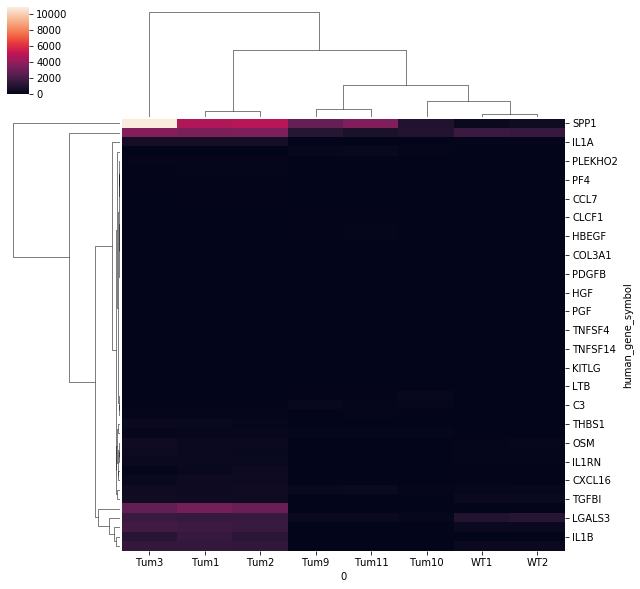

In [300]:
# リガンドだけを可視化
## うまくいっているなら、Tum1, Tum2, Tum3 (腫瘍組織内マクロファージ)で多く、WT1, WT2 (野生型) で少ない
sns.clustermap(x1)

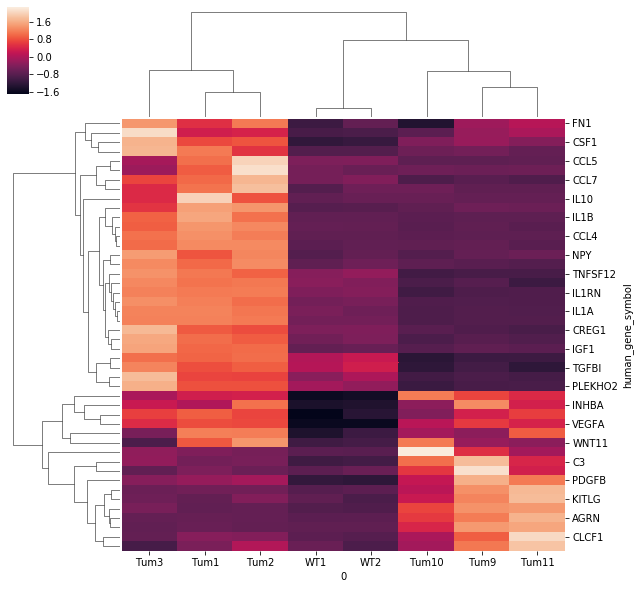

In [301]:
sns.clustermap(x1,z_score=0)

In [304]:
x2=x[(x["human_gene_symbol"].isin(dflr_pair["To"]) ==True)]
x2 = x2.set_index('human_gene_symbol')
x2.head()

,Tum1,Tum2,Tum3,WT1,WT2,Tum9,Tum10,Tum11
human_gene_symbol,,,,,,,,
ACVR1,6.484450,8.62599,10.393900,7.75611,8.94192,16.37830,14.98080,14.11140
ACVR1B,8.271760,6.84239,11.129900,17.47970,18.43730,17.70060,17.17310,15.93750
ACVR2A,3.182070,2.72893,2.464480,2.76712,2.57328,5.85468,5.16139,5.75575
ACVR2B,0.981347,0.64447,0.826287,2.33342,2.37014,1.61612,2.12798,1.48071
AXL,230.212000,230.83700,331.285000,343.90600,366.91300,59.17080,25.95220,63.21420


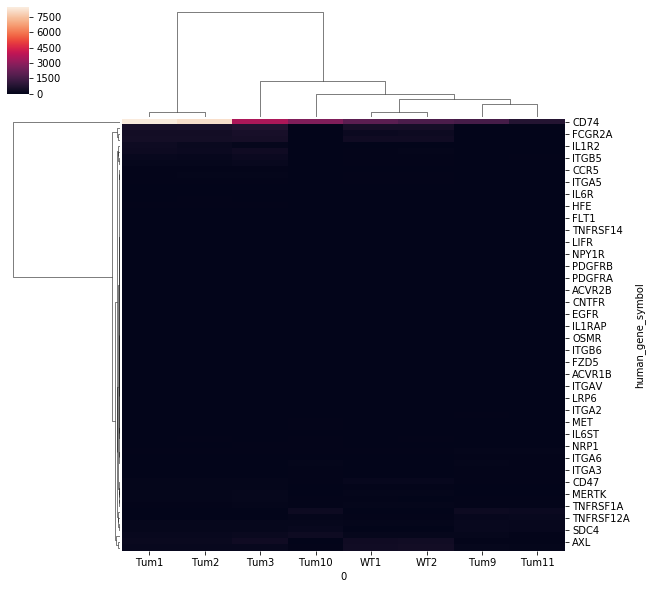

In [306]:
# 受容体だけを可視化
## うまくいっているなら、Tum9, Tum10, Tum11 で多い
sns.clustermap(x2)

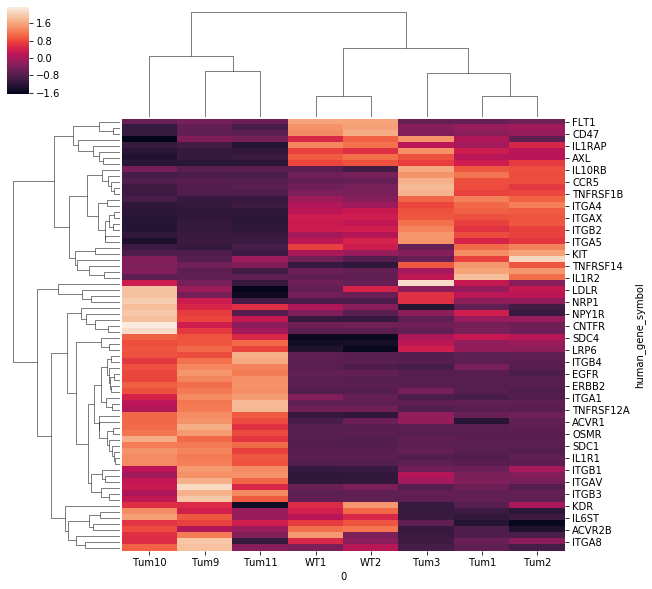

In [307]:
sns.clustermap(x2,z_score=0)

このあとどうするか？
今のままでは、候補がかなり多いため、仮説を検証する実験をするのは難しそうです。また、この予測がどのくらい正しいのかも不明です。

元論文では、このリガンド-受容体ペアを足がかりに、以下のような解析をします。

受容体の下流のシグナル伝達経路から転写因子があるか探す（パスウェイデータベースを参照する）
それらの下流の転写因子がターゲットとする遺伝子を探す（パスウェイデータベースや遺伝子制御関係のデータベースを参照する）
それらのターゲット遺伝子群にランダムに比べて発現変動遺伝子が濃縮しているかを調べる（統計検定）
このような解析を加えることで、単にリガンドと受容体が共起だけでなく、さらに信頼性のあるペアを探すことができます。

ちなみに、著者らはこの方法をCCCExplorerと名付けています。詳しくは元の論文をご覧ください:

Toi et al., Transcriptome Analysis of Individual Stromal Cell Populations Identifies Stroma-Tumor Crosstalk in Mouse Lung Cancer Model, Cell Reports (2015) http://dx.doi.org/10.1016/j.celrep.2015.01.040

## 小まとめ

このようにIDによる統合を繰り返すだけでもいろいろな仮説を立てられます。また、NGS解析とは言いつつ、NGSデータ以外の生命科学データを合わせることで、単なる発現変動遺伝子のリストよりも深い知見が得られるうることがみえてきたかと思います。


## 編集者まとめ

趣味の一環でデータ解析を行ってます。Rのデータ解析をPythonでできないものかと、Rを読めないのに行ってます。
Python歴もまだ三ヶ月なため間違ってるところもあるかと思いまが、ご了承ください。
